<a href="https://colab.research.google.com/github/justinePrasad/HofstraASPiRe2023/blob/main/NodeClassificationGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch

In [2]:
import torch

print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [3]:
#installs based on version
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [4]:
!pip install torch_geometric

Importing Dataset


In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root="/tmp/Cora", name="Cora", transform=NormalizeFeatures())

Looking at Data Distruution

In [6]:
print()
print(f'Dataset: {dataset}')
print('====================')
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

data=dataset[0]

print()
print(data)
print('================================================================')

#gather statistics about the graph
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f"Average Node Degree:  {data.num_edges / data.num_nodes :.2f}")
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


print(dataset.num_classes) #output dimension
print(dataset.num_features) #input dimension


print(f"Node Features: {data.x}")
print(f"Node Labels: {data.y}")
print(f"Adj. List: {data.edge_index}")
print(data) #attributes of data


Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average Node Degree:  3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True
7
1433
Node Features: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Node Labels: tensor([3, 4, 4,  ..., 3, 3, 3])
Adj. List: tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [7]:
#Finding the distrubution
num_edges = data.edge_index.shape[1] #why is it shape 1
num_nodes = data.x.shape[0]

avg_cit = num_edges/num_nodes
print(f"Avg. Number of citations per paper: {avg_cit}")

Avg. Number of citations per paper: 3.8980797636632203


In [8]:
import numpy as np

#distrubution of each word in papers
word_counts = np.sum(data.x.numpy(), axis=0)
word_dis = word_counts/ num_nodes

print(f"Word Distribution: {word_dis}") #represents freq of each word across all papers

Word Distribution: [0.00027324 0.00062631 0.00129225 ... 0.00013502 0.0012015  0.00022694]


Visualizing Data

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

edge_index = data.edge_index.numpy()
G = nx.Graph()
for i in range(edge_index.shape[1]):
  G.add_edge(edge_index[0,i], edge_index[1,i]) #source and target node respectively

#calc the degrees
degrees = [G.degree(n) for n in G.nodes()]

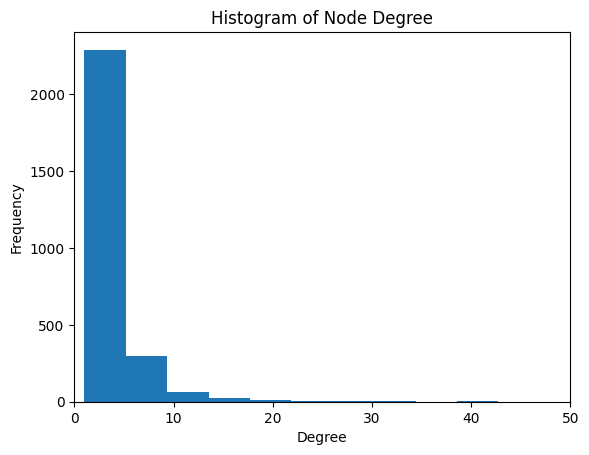

In [10]:
#create the histogram
plt.hist(degrees, bins=40)
plt.title('Histogram of Node Degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.xlim([0,50])
plt.show()

Data preprocessing


In [11]:
import scipy.sparse

#feature matrix
data = dataset[0]
#2708 by 1433
feature_matrix = data.x.numpy()

#adj matrix -> can be inferred from the 'edge index' attribute
num_nodes = data.num_nodes
edge_index = data.edge_index.numpy()

#args (data, (i,j)), shape
adj_matrix = scipy.sparse.coo_matrix((np.ones(edge_index.shape[1]), edge_index), shape=(num_nodes, num_nodes))

In [12]:
# %%script false
# #test to make sure edges are correctly represented

# #checks each edge in edge_index and sees if the corresponding entry is
# scr_matrix = adj_matrix.tocsr()

# for i in range(20):
#   source = edge_index[0,i]
#   target = edge_index[1, i]

#   if scr_matrix[source, target] != 1:
#     print(f"Edge ({source}, {target}) is not correctly represented")

Training GCN Model

In [21]:
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
#During init:parameters dataset.num_features and hidden_channels define the
#size of the feature vectors that the layer expects to receive and produce

#During execution,it needs two pieces of data to do its work: the feature vectors for the nodes (x)
# and the structure of the graph (edge_index).

#'H' heads and if each H computes 'F', then the total # of features is H*F

class GAT(torch.nn.Module):
  def __init__(self, hidden_channels, heads):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GATConv(dataset.num_features, hidden_channels, heads)
    self.conv2 = GATConv(8 * hidden_channels, dataset.num_classes, heads=1)

#defines the forward pass of the network
#Inputs: x - node features of graph, edge_index - connections between nodes
  def forward(self, x, edge_index):
    x = F.dropout(x, p=0.6, training=self.training)
    x = self.conv1(x, edge_index)
    #ReLU func is applied ensuring that the network can learn complex patterns
    x = F.elu(x)
    #Dropout prevents overfitting
    x = F.dropout(x, p=0.6, training=self.training)
    x = self.conv2(x, edge_index)
    return x

In [14]:
model = GAT(hidden_channels=8, heads=8)
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(8, 7, heads=1)
)


Using TSNE to visualize node on 2D plane

In [15]:
#Todo comment how code works

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

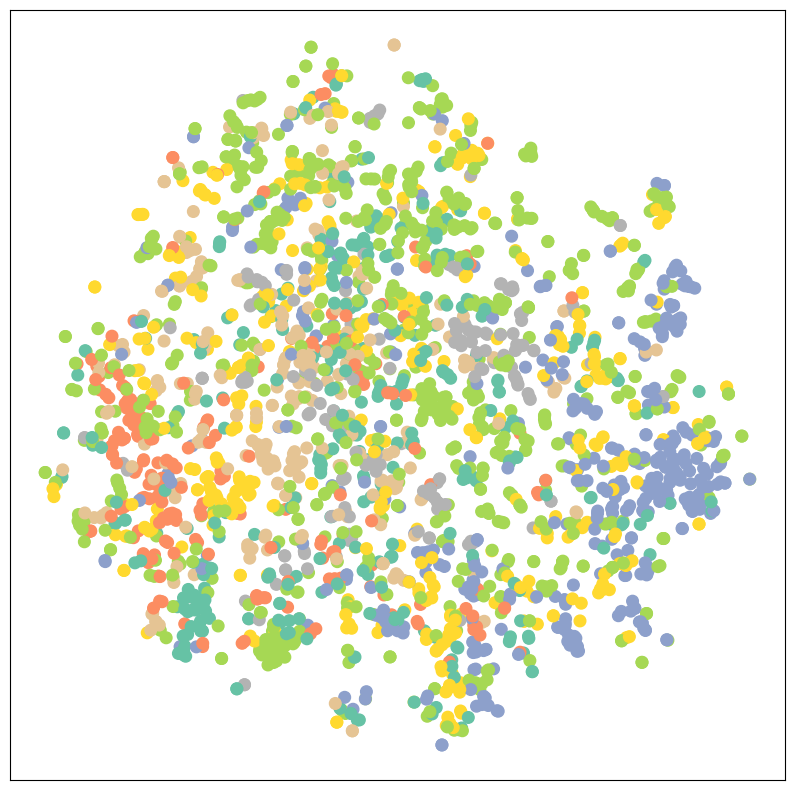

In [22]:
model = GAT(hidden_channels=8, heads = 8)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color = data.y)

Training and Testing Model

In [23]:
from IPython.display import Javascript #to restrict height of output cell
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT(hidden_channels=8, heads = 8) #what would happen with more channels

#inits an optimizer with a specific learning rate and weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = 5e-4)
#Common loss function that is used
criterion = torch.nn.CrossEntropyLoss()

def train():
  model.train() #switches to training mode
  optimizer.zero_grad() #clear gradients from last step
  out = model(data.x, data.edge_index) #does a single forward pass
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) #compute loss from training nodes
  loss.backward() #derive gradients
  optimizer.step() #update parameters based on gradients
  return loss

def test(mask):
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1) #Use the class with the highest probability
  correct = pred[mask] == data.y[mask] #In order to check against ground-truth labels
  acc = int(correct.sum()) / int(mask.sum())
  return acc

for epoch in range(1, 101):
  loss = train()
  val_acc = test(data.val_mask)
  test_acc = test(data.test_mask)
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.3f}. Test: {test_acc:.3f}')


<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9445, Val: 0.358. Test: 0.402
Epoch: 002, Loss: 1.9268, Val: 0.620. Test: 0.638
Epoch: 003, Loss: 1.9029, Val: 0.742. Test: 0.736
Epoch: 004, Loss: 1.8800, Val: 0.734. Test: 0.725
Epoch: 005, Loss: 1.8570, Val: 0.746. Test: 0.738
Epoch: 006, Loss: 1.8426, Val: 0.742. Test: 0.741
Epoch: 007, Loss: 1.8082, Val: 0.756. Test: 0.760
Epoch: 008, Loss: 1.7840, Val: 0.776. Test: 0.775
Epoch: 009, Loss: 1.7602, Val: 0.778. Test: 0.785
Epoch: 010, Loss: 1.7252, Val: 0.786. Test: 0.795
Epoch: 011, Loss: 1.6861, Val: 0.782. Test: 0.806
Epoch: 012, Loss: 1.6548, Val: 0.786. Test: 0.805
Epoch: 013, Loss: 1.6103, Val: 0.790. Test: 0.809
Epoch: 014, Loss: 1.6038, Val: 0.790. Test: 0.813
Epoch: 015, Loss: 1.5454, Val: 0.792. Test: 0.816
Epoch: 016, Loss: 1.4905, Val: 0.804. Test: 0.815
Epoch: 017, Loss: 1.4855, Val: 0.802. Test: 0.816
Epoch: 018, Loss: 1.4246, Val: 0.808. Test: 0.812
Epoch: 019, Loss: 1.3940, Val: 0.806. Test: 0.804
Epoch: 020, Loss: 1.3484, Val: 0.804. Test: 0.795


Results of Different Model Architecture

3 GCN Layers: Epoch: 100, Loss: 0.7956, Val: 0.786. Test: 0.794

2 GCN Layers: Epoch: 100, Loss: 0.5799, Val: 0.778. Test: 0.815

2 Layer GAT: Epoch: 100, Loss: 0.2573, Val: 0.790. Test: 0.785  Note: Might be overfiting

2 GCN layer mode performs better

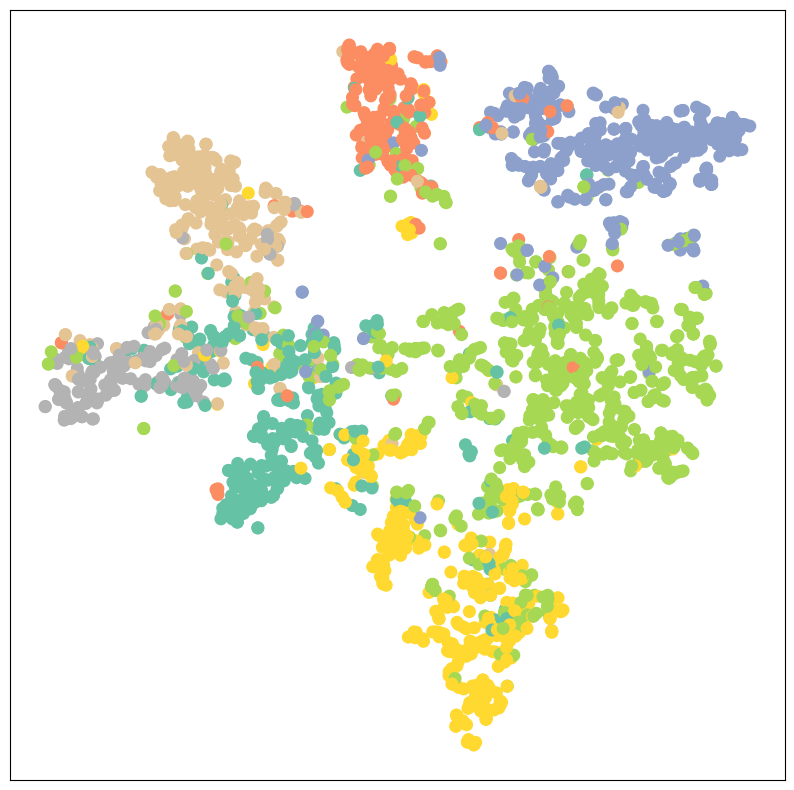

In [24]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)